## Spectral Methods in Python 1

by [Abhilash Reddy M](https://www.abhilashreddy.com)

This is me building up on the problems given by Lloyd N. Trefethen in his book *Spectral Methods in MATLAB*. There are a few different python implementations of the original matlab codes available. I have lifted the `cheb` function from [another-chebpy](https://github.com/mewilliams/another-chebpy). 

In [1]:
import numpy as np
from scipy.linalg import solve
from matplotlib import pyplot as plt
from scipy.sparse.linalg import bicgstab,gmres,LinearOperator

In [2]:
def cheb(N):
    x = np.cos(np.pi*np.linspace(N,0,N+1)/N)
    c=np.zeros(N+1)
    c[0]=2.
    c[1:N]=1.
    c[N]=2.
    c = c * (-1)**np.linspace(0,N,N+1)
    X = np.tile(x, (N+1,1))
    dX = X - X.T
    D = np.dot(c.reshape(N+1,1),(1./c).reshape(1,N+1))
    D = D / (dX+np.eye(N+1))
    D = D - np.diag( D.T.sum(axis=0) )
    return D,x

This function returns a differentiation matrix $D$ and the collocation points $x$ on the canonical [-1,1] domain, including the boundary points. If $u$ is the column vector containing values sampled at $x$, then $Du$ gives the first derivative of u. Similarly, $DDu=D^2u$ gives the second derivative of $u$. The differentiation matrix has N+1 rows and columns. This will be used to build our discrete differential operator.

### Problem 1: 1D BVP with Homogenous BCs

A simple problem to start with is a elliptic two point BVP, problem 13 in Trefethen's book, which reads:

$$
u_{xx}=e^{4x},~~~u(-1)=u(1)=0
$$

The exact solution is $u=\frac{1}{16}(e^{4x} -sinh(4)x -cosh(4))$

Here, the solution is reproduced from  [another-chebpy](https://github.com/mewilliams/another-chebpy). The boundary conditions are enforced by deleting the rows and columns corresponding to the boundary points, since the value of the solution is zero at those points. Subsequent examples show how one can handle inhomogenous BCs

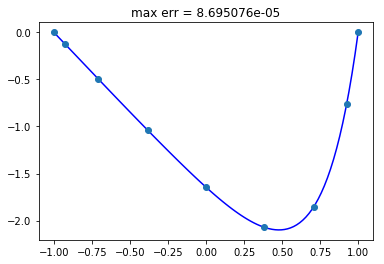

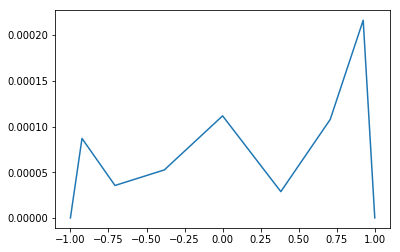

In [3]:
N=8
D,x=cheb(N)
D2=np.dot(D,D)
D2=D2[1:N,1:N]
f=np.exp(4.*x[1:N])
u=solve(D2,f)
s=np.zeros(N+1)
s[0]=0.0
s[N]=0.0
s[1:N]=u

exact=(np.exp(4.*x)-np.sinh(4.)*x-np.cosh(4))/16.
maxerr=np.max(s-exact)

xx=np.linspace(-1.,1.,100)
uu = np.polyval(np.polyfit(x,s,N),xx)    # interpolate grid data

plt.title('max err = %e' % maxerr)
plt.plot(xx,uu,'b',x,exact,'o')
plt.figure()
plt.plot(x,np.abs(s-exact))
plt.show()

### Problem 2: 1D inhomogenous BVP with multi-domain method

This problem is similar to the last but divides the domain into two sections and applies the spectral discretization separately to each section. 

$$
u_{xx} = e^{4x},~~u(0)=1, u(1)=1
$$

The exact solution is $u(x)=\frac{1}{16}(e^{4x} - (e^4-17)x - 1)$

The domain is split into [0,a] and [a,1] and each part is discretized separately. Since the discretization includes the boundary point, the two subdomains share one point. At the shared point, we require that the solution and the first derivative be continuous. The parameter $a$ can be changed to change where the domain is split. 

The other thing shown here is that the [-1,1] canonical domain is remapped to the physical domain for each part. It is just translation and scaling in 1D. Furthermore, this example shows the application of inhomogenous dirichlet BCs. This technique can be extended for other general BCs as well.


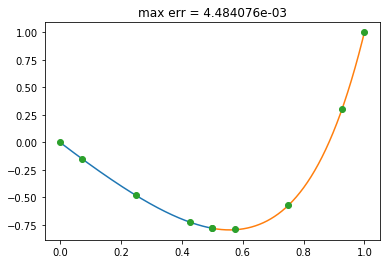

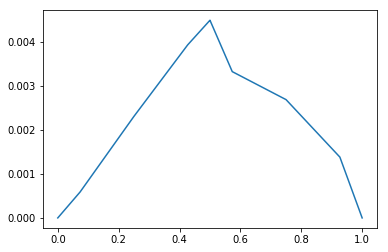

In [4]:
N = 4

Dglobal=np.zeros([2*N+2,2*N+2])
f=np.zeros(2*N+2)

a = 0.5

#part one[0,a]
D1_p1,x=cheb(N)
x1=0.5*(0+a)+0.5*(a-0)*x

D1_p1=D1_p1/(0.5*(a-0))
D2_p1=np.dot(D1_p1,D1_p1)

#part two [a,1]
D1_p2,x=cheb(N)
x2=0.5*(1+a)+0.5*(1-a)*x

D1_p2=D1_p2/(0.5*(1-a))
D2_p2=np.dot(D1_p2,D1_p2)

#set most of the RHS
f[1:N]=np.exp(4.*x1[1:N])
f[N+2:2*N+1]=np.exp(4.*x2[1:N])

# set second derivative matrix for the first part
Dglobal[1:N,0:N+1]=D2_p1[1:N,0:N+1]

#set value at element edge to be equal
Dglobal[N,N]   = 1
Dglobal[N,N+1] = -1

#set first derivatives of shared point to be equal
Dglobal[N+1,0:N+1]= D1_p1[N,0:N+1]
Dglobal[N+1,N+1:2*N+2]= -D1_p2[0,0:N+1]

#set second derivative matrix for the second part
Dglobal[N+2:2*N+1,N+1:2*N+2]=D2_p2[1:N,0:N+1]

#set BCs
Dglobal[0,0]   = 1.0
Dglobal[-1,-1] = 1.0

f[0]  = 0.
f[-1] = 1.0

u=solve(Dglobal,f)

xp=np.r_[x1,x2]

exact=1./16.*(np.exp(4.*xp)-(np.exp(4)-17)*xp - 1)
error=np.abs(u-exact)
maxerr=np.max(error)


#element wise interpolation because the inter-element boundary node repeats
xx1=np.linspace(0,a,500)
uu1 = np.polyval(np.polyfit(x1,u[0:N+1],N),xx1)

xx2=np.linspace(a,1.0,500)
uu2 = np.polyval(np.polyfit(x2,u[N+1:2*N+2],N),xx2)

plt.title('max err = %e' % maxerr)
plt.plot(xx1,uu1,'-')
plt.plot(xx2,uu2,'-')
plt.plot(xp,exact,'o')

plt.figure()
plt.plot(xp,error)

plt.show()

A global coefficient matrix was assembled for the last problem. That can be avoided as all we need is the action of the matrix on a vector. Another way of looking at it is solving it with a domain decomposition method algorithm.

### Problem 3: Nonlinear problem with JFNK

A nonlinear problem of the form $ u_{xx} = f(u,x)$ is solved using a Jacobian-free Newton-Krylov method. The problem is recast to find $u$ such that $F(u,x) = u_{xx} - f(u,x) = 0$

$$
F(u,x)=u_{xx}-\sin{\pi u_x}-\cos{(2\pi u)} e^{10u^2}-5\sin{2\pi x}
$$


First we define our approximate jacobian function. 

In [5]:
def jv(F,u):
  ''' approximation of jacobian action on krylov vector
  '''
  dim = len(u)
  def jv_approx(v):
    eps=2e-16

    sum = np.sqrt(eps) * np.sum((1.0 + u))
    if(np.linalg.norm(v,2) > eps):
      per = sum / (dim * np.linalg.norm(v, 2))
    else:
      per = sum / dim
     
    y = (F(u + per * v ) - F(u - per * v) ) / (2*per)
    return y
  A = LinearOperator((dim,dim), matvec=jv_approx)
  return A

This uses central difference to approximate the action of the jacobian on a vector. It has two function calls due to the central difference formula. We could have done with one function call as well, using a forward difference or backward difference. F(u) is available at each iteration. We return a `LinearOperator` object.

Discretize the domain and define the function

In [6]:
N=16
D,x=cheb(N)
D2=np.dot(D,D)
D=D[1:N,1:N]
D2=D2[1:N,1:N]
nevals=0
def F(u):
  global nevals
  nevals+=1
  return (np.dot(D2,u)-np.sin(np.pi*np.dot(D,u))-np.cos(2*np.pi*u)*np.exp(10*u**2) - 5*np.sin(2*np.pi*x[1:N]))

The BCs are homogenous dirichlet so, we deal with that by deleting the rows and columns from our matrix. we start with an initial guess of zeros and solve

0 10.8862945903 0.757124192485 -0.291938603971
1 1.97298477431 0.20617882407 -0.235835383165
2 0.0434671565449 0.0377755923985 -0.227784582082
3 0.000132354653728 0.0025813663304 -0.226859164108
4 1.39359115281e-09 8.86712094656e-06 -0.226855785735
total number of function evaluations is  196


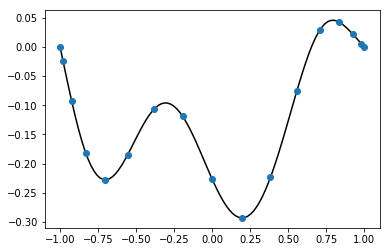

In [7]:
u=0.0*np.ones(N-1)
R=F(u)
err=np.zeros(N-1)
change = 0.1 # arbitrary small number
it = 0

while True:

  j_v_approx=jv(F,u)
  v,_=gmres(jv(F,u),R,tol=6e-6)

  u=u-v
  R=F(u)
  print(it,np.linalg.norm(R,2),np.linalg.norm(v,2),u[N//2-1]) 

  it += 1
  if(it > 50):
    break

  if(np.max(np.abs(R)) < 6e-6):
    break

print('total number of function evaluations is ', nevals)
s=np.zeros(N+1)
s[0]=0.0
s[N]=0.0
s[1:N]=u

xx=np.linspace(-1.,1.,100)
uu = np.polyval(np.polyfit(x,s,N),xx)

plt.plot(xx,uu,'k',x,s,'o')
plt.show()

The number of function evaluations is not small! Lets see how scipy's newton_krylov does.

In [8]:
from scipy.optimize import newton_krylov
nevals=0
u=newton_krylov(F,0.0*np.ones(N-1))
print('total number of evaluations is ', nevals)
print(u[N//2-1])

total number of evaluations is  72
-0.226855819995


[Back to Mainpage](www.abhilashreddy.com)